# Importation des bibliothèques nécessaires

In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy.lib.stride_tricks import sliding_window_view as swv
sns.set_theme(rc={'figure.figsize':(11.7, 8.27)})
from keras import callbacks


# Importation des données

In [94]:
rec_ind_data = pd.read_csv('rec_ind_data.csv', sep= ',')
rec_ind_data
nbjours = pd.read_csv('plusieurs_jours_n.csv',sep=',')
av_pdo =pd.read_csv('plusieurs_jours_n.csv',sep=',')

def ajoute_val_prec(colonnes,data,n):
    #### ajoute des nouvelles colonnes à la dataframe, contenant les 'n' valeurs précédentes issues de la liste 'colonnes'

    #### cette fonction prend les variable suivantes en entrée :
    # n = nombre de valeurs précédentes à mettre dans le liste
    # data = dataframe contenant toutes les variables
    # colonne = nom de la colonne dans la datframe
    
    #### et rend la variable suivante en sortie :
    # data_n = l'ancienne dataframe à laquelle on a ajouté la nouvelle colonne
    N = data.shape[0]
    data_n=data.copy()
    data_n = data_n[n:]
    for colonne in colonnes : 
        b_liste=[]
        for i in range(n,N) :
            liste = []
            for k in range(n,0,-1):
                liste.append(data[colonne].values[i-k])
            b_liste.append(liste)
        data_n['liste de '+colonne]=b_liste
    return (data_n)

new_data = ajoute_val_prec(['MMM','dhw','thermal_stress_category','phioc','puissance','puissance STL'],av_pdo,30)
new_data = pd.merge(new_data,rec_ind_data)
new_data = new_data[['MMM', 'dhw', 'thermal_stress_category', 'phioc', 'puissance', 'puissance STL']].values
new_data = np.array(new_data)

# LSTM avec historique des données

In [95]:
# Fonction pour créer des séquences
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        target = data[i + window_size]
        sequences.append(np.array(sequence))
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Paramètres
WINDOW_SIZE = 3
# Préparer les données
X, y = create_sequences(new_data, WINDOW_SIZE)

NUM_FEATURES = X.shape[2]
NUM_OUTPUTS = y.shape[1]

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=2024)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (88, 3, 6)
Shape of y_train: (88, 6)


In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, NUM_FEATURES), name='input'),
    tf.keras.layers.BatchNormalization(name='norm'),
    tf.keras.layers.LSTM(3, activation='relu', name='lstm'),
    tf.keras.layers.Dense(NUM_OUTPUTS, name='pred')
], name='Recouvrement')

model.compile(optimizer='adam', loss='mae', metrics=['mse'])
model.summary()

Model: "Recouvrement"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ norm (BatchNormalization)       │ (None, 3, 6)           │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 6)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 156 (624.00 B)

 Non-trainable params: 12 (48.00 B)

In [97]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=300,callbacks=[earlystopping])

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6176.0498 - mse: 146686000.0000 - val_loss: 6254.1025 - val_mse: 148255280.0000
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5889.5073 - mse: 134356144.0000 - val_loss: 6254.1846 - val_mse: 148257456.0000
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5835.5029 - mse: 129865664.0000 - val_loss: 6254.1953 - val_mse: 148258080.0000
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5916.5908 - mse: 136599104.0000 - val_loss: 6254.1899 - val_mse: 148258320.0000
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6011.8218 - mse: 140538272.0000 - val_loss: 6254.1807 - val_mse: 148258416.0000
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5928.1006 - mse: 134343408.0000 - val_loss: 6254.1680 - val_mse: 148258400.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5842.3721 - mse: 131925720.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


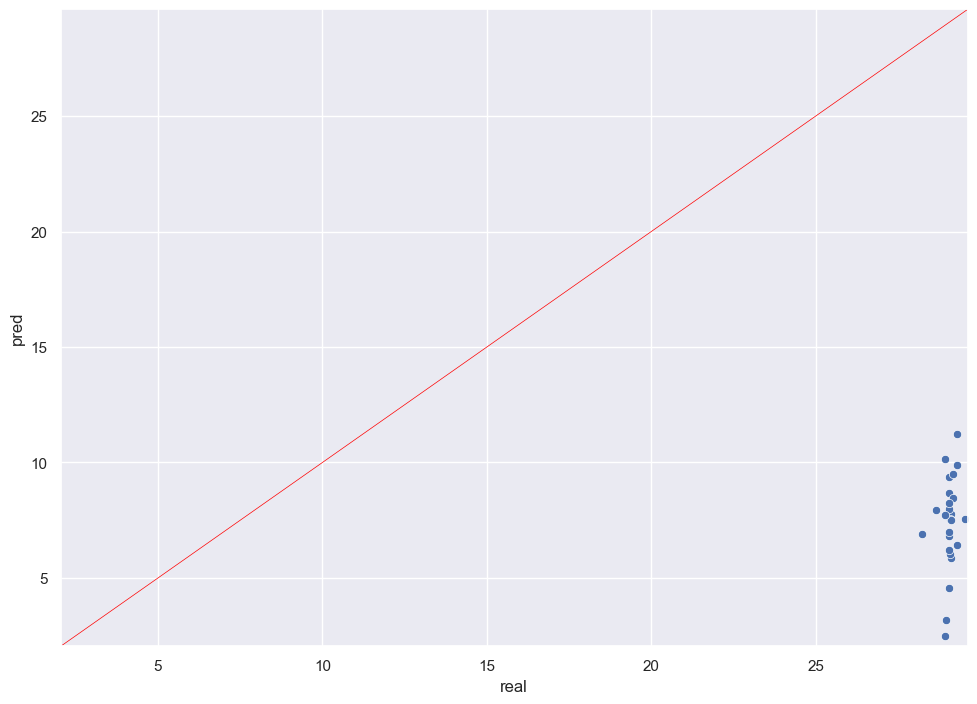

r2 : -8902.768309099436
rmse : 21.743065920079754


In [98]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test).squeeze()

df_test = pd.DataFrame({'real': y_test[:, 0], 'pred': y_pred[:, 0]})
ax = sns.scatterplot(data=df_test, x='real', y='pred')
xl, xr = ax.get_xlim()
yb, yt = ax.get_ylim()
ax.set_xlim(min(xl, yb), max(xr, yt))
ax.set_ylim(min(xl, yb), max(xr, yt))
ax.axline([ax.get_xlim()[0], ax.get_xlim()[0]],
          [ax.get_xlim()[1], ax.get_xlim()[1]],
          color='red', lw=0.5)
plt.show()

print("r2 :", metrics.r2_score(y_test[:, 0], y_pred[:, 0]))
print("rmse :", np.sqrt(metrics.mean_squared_error(y_test[:, 0], y_pred[:, 0])))

# LSTM sans l'historique des données

In [7]:
X = rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre']]
y = rec_ind_data['recouvrement corr %']

WINDOW_SIZE = 3  # consecutive days
NUM_FEATURES = X.shape[1]

X = swv(X, window_shape=(WINDOW_SIZE, NUM_FEATURES))[:-1].squeeze()
y = y[WINDOW_SIZE:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=2024)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, NUM_FEATURES), name='input'),
    tf.keras.layers.BatchNormalization(name='norm'),
    tf.keras.layers.LSTM(3, activation='relu', name='lstm'),
    tf.keras.layers.Dense(1, name='pred')
], name='Recouvrement')

model.compile(optimizer='adam', loss='mae', metrics=['mse'])
model.summary()

Model: "Recouvrement"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ norm (BatchNormalization)       │ (None, 3, 5)           │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132 (528.00 B)

 Trainable params: 122 (488.00 B)

 Non-trainable params: 10 (40.00 B)

In [11]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=300,callbacks=[earlystopping])

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 27.8115 - mse: 913.3363 - val_loss: 26.3158 - val_mse: 758.3184
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.8286 - mse: 920.2966 - val_loss: 25.1479 - val_mse: 699.6586
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.0242 - mse: 920.5306 - val_loss: 24.0769 - val_mse: 647.2748
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.3381 - mse: 943.3657 - val_loss: 23.4807 - val_mse: 618.3889
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.6086 - mse: 956.8967 - val_loss: 23.1328 - val_mse: 601.3774
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.6761 - mse: 975.2047 - val_loss: 22.9268 - val_mse: 590.7689
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.4840 - mse: 953.4353 - val_loss: 22.8174 - val_mse: 585.0974
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.6935 - mse: 955.2971 - val_loss: 22.7516 - val_mse: 581.7521
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13.1641 - mse: 247.1311
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


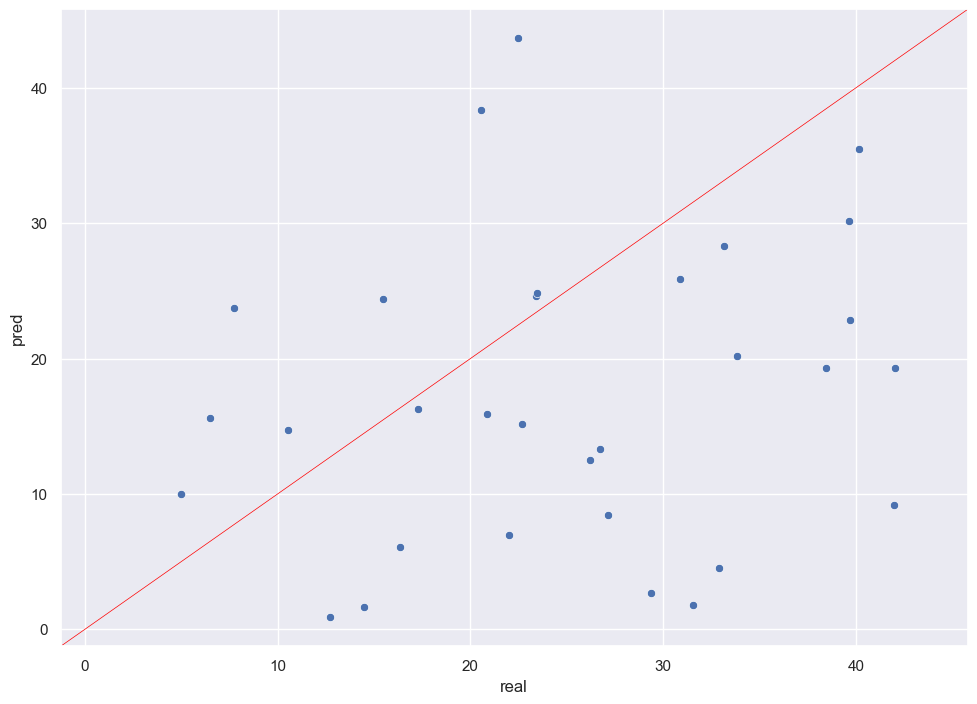

r2 : -1.166457582329775
rmse : 15.720403694868317


In [12]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test).squeeze()
df_test = pd.DataFrame({'real': y_test, 'pred': y_pred})
ax = sns.scatterplot(data=df_test, x='real', y='pred')
xl, xr = ax.get_xlim()
yb, yt = ax.get_ylim()
ax.set_xlim(min(xl, yb), max(xr, yt))
ax.set_ylim(min(xl, yb), max(xr, yt))
ax.axline([ax.get_xlim()[0], ax.get_xlim()[0]],
          [ax.get_xlim()[1], ax.get_xlim()[1]],
          color='red', lw=0.5)
plt.show()

print("r2 :", metrics.r2_score(y_test, y_pred))
print("rmse :", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))